In [ ]:
""" Code for plotting Fig 5 and Supp Fig 17: Trained ControlNet model predictions on test set """

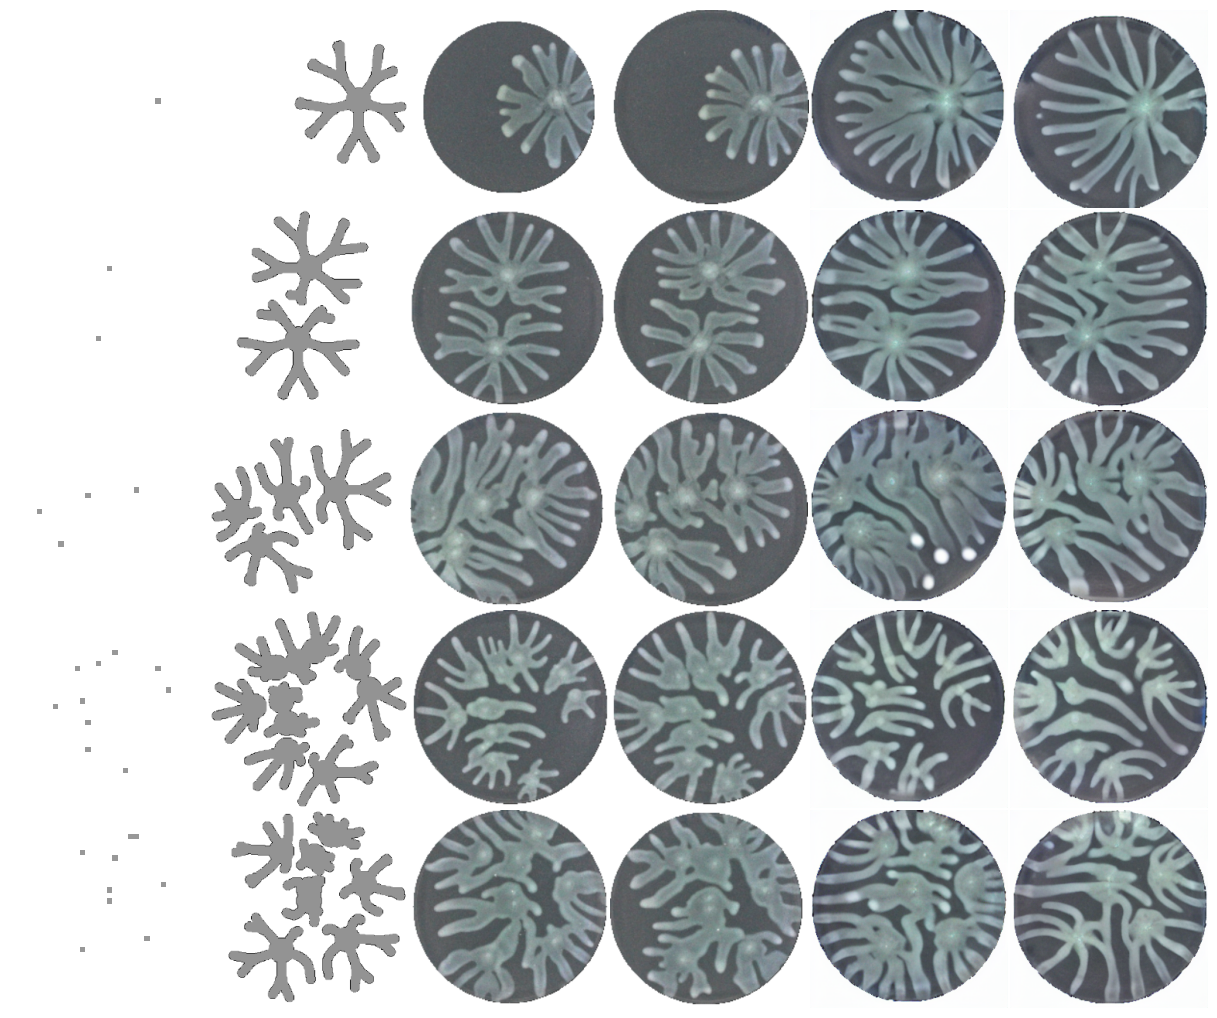

Processed 5 samples using preprocess_experimental and preprocess_simulation functions


In [3]:
"""
Sim conditioning Fig 5
"""

import matplotlib.pyplot as plt
import re
import os
import glob
import torch
import numpy as np
import cv2
from cldm.preprocess import grayfordisplay,preprocess_experimental_backgroundwhite, preprocess_simulation_graybackground
from cldm.config import SEED_FOLDER_TEST, SIM_FOLDER_TEST,EXP_FOLDER_TEST,MAIN_FOLDER

# ——— CONFIG ———
sample_ids = [198, 196, 200, 227, 245]   # your conditions
n_exp    = 2                   # number of real-exp replicates
n_pred   = 2                   # number of model samples per condition

folders = {
    "seed": SEED_FOLDER_TEST,
    "sim":  SIM_FOLDER_TEST,
    "exp":  EXP_FOLDER_TEST,
    "pred": MAIN_FOLDER
}


# ——— GATHER PATHS (same as before) ———
seed_paths = {}
for sid in sample_ids:
    m = glob.glob(f"{folders['seed']}/{sid}_*.png")
    if not m:
        raise FileNotFoundError(f"No seed for sample {sid}")
    seed_paths[sid] = m[0]

sim_paths = {}
for sid in sample_ids:
    sims = glob.glob(f"{folders['sim']}/{sid}_*.TIF")
    if not sims:
        raise FileNotFoundError(f"No sim for sample {sid}")
    sim_paths[sid] = sorted(
        sims,
        key=lambda f: int(re.search(rf"{sid}_(\d+)\.TIF", f).group(1))
    )[0]

def sorted_reps(folder, sid, ext, n):
    files = glob.glob(f"{folder}/{sid}_*.{ext}")
    return sorted(
        files,
        key=lambda f: int(re.search(rf"{sid}_(\d+)\.{ext}", f).group(1))
    )[:n]

def sorted_reps_pred(folder, sid, n):
    pattern = os.path.join(folder, f"{sid}_*")
    files = [f for f in glob.glob(pattern) if f.lower().endswith('.png')]
    files = sorted(files, key=lambda f: int(os.path.splitext(f)[0].split('_')[-1]))
    return files[:n]

exp_paths  = {sid: sorted_reps(folders['exp'],  sid , 'TIF', n_exp)  for sid in sample_ids}
pred_paths  = {sid: sorted_reps_pred(folders['pred'],  sid, n_pred)  for sid in sample_ids}

# ——— PROCESS IMAGES WITH PREPROCESSING FUNCTIONS ———
processed_images = {}

for sid in sample_ids:
    processed_images[sid] = {}
    
    # Process seed image (use Image.open for seeds since they're already processed)
    seed_processed = grayfordisplay(seed_paths[sid], img_type='seed')
    processed_images[sid]['seed'] = seed_processed

    # Process simulation image with preprocess_simulation
    sim_processed = preprocess_simulation_graybackground(sim_paths[sid])
    processed_images[sid]['sim'] = sim_processed
    
    # Process experimental images with preprocess_experimental
    processed_images[sid]['exp'] = []
    for exp_path in exp_paths[sid]:
        exp_processed = preprocess_experimental_backgroundwhite(exp_path)
        processed_images[sid]['exp'].append(exp_processed)
    
    # Process prediction images (simple cv2 read with background conversion)
    processed_images[sid]['pred'] = []
    for pred_path in pred_paths[sid]:
        pred_processed = cv2.imread(pred_path)
        pred_processed = cv2.cvtColor(pred_processed, cv2.COLOR_BGR2RGB)
        # Apply thresholding and background conversion
        pred_processed = cv2.threshold(pred_processed, 10, 255, cv2.THRESH_TOZERO)[1]
        pred_processed[np.all(pred_processed == [0,0,0], axis=-1)] = [255,255,255]
        processed_images[sid]['pred'].append(pred_processed)

# ——— PLOT PROCESSED IMAGES ———
ncols = 2 + n_exp + n_pred
fig, axes = plt.subplots(
    len(sample_ids), ncols,
    figsize=(ncols*2, len(sample_ids)*2),
    layout='constrained',
)

for i, sid in enumerate(sample_ids):
    # Seed (grayscale)
    axes[i,0].imshow(processed_images[sid]['seed'], cmap='gray')
    axes[i,0].axis('off')
    
    # Sim (grayscale)
    axes[i,1].imshow(processed_images[sid]['sim'], cmap='gray')
    axes[i,1].axis('off')
    
    # Experimental replicates (grayscale)
    for j in range(n_exp):
        if j < len(processed_images[sid]['exp']):
            axes[i, 2+j].imshow(processed_images[sid]['exp'][j], cmap='gray')
            axes[i, 2+j].axis('off')
    
    # Model predictions (color)
    for k in range(n_pred):
        if k < len(processed_images[sid]['pred']):
            axes[i, 2+n_exp+k].imshow(processed_images[sid]['pred'][k])
            axes[i, 2+n_exp+k].axis('off')

fig.get_layout_engine().set(w_pad=0.01, h_pad=0.01, hspace=0.01, wspace=0.01)
plt.show()

print(f"Processed {len(sample_ids)} samples using preprocess_experimental and preprocess_simulation functions")

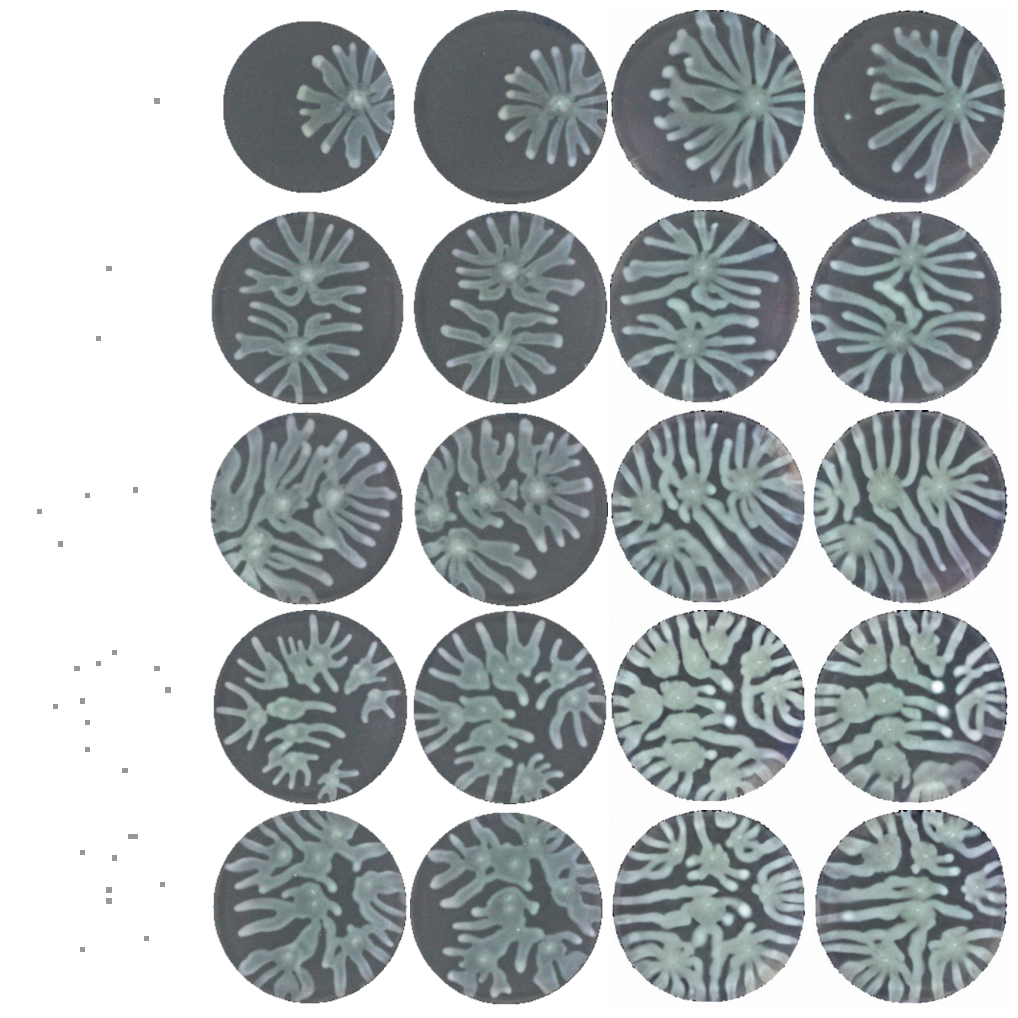

Processed 5 samples using preprocess_experimental and preprocess_simulation functions


In [2]:
"""
Using seed conditioned model predictions
"""
import matplotlib.pyplot as plt
import re
import os
import glob
import torch
import numpy as np
import cv2
from cldm.preprocess import grayfordisplay,preprocess_experimental_backgroundwhite, preprocess_simulation_graybackground
from cldm.config import SEED_FOLDER_TEST,EXP_FOLDER_TEST,PRED_FOLDER_SEEDTOEXP

# ——— CONFIG ———
sample_ids = [198, 196, 200, 227, 245]   # your conditions
n_exp    = 2                   # number of real-exp replicates
n_pred   = 2                   # number of model samples per condition

folders = {
    "seed": SEED_FOLDER_TEST,
    "exp":  EXP_FOLDER_TEST,
    "pred": PRED_FOLDER_SEEDTOEXP
}

# ——— GATHER PATHS (same as before) ———
seed_paths = {}
for sid in sample_ids:
    m = glob.glob(f"{folders['seed']}/{sid}_*.png")
    if not m:
        raise FileNotFoundError(f"No seed for sample {sid} in {folders['seed']}")
    seed_paths[sid] = m[0]

def sorted_reps(folder, sid, ext, n):
    files = glob.glob(f"{folder}{sid}_*.{ext}")
    return sorted(
        files,
        key=lambda f: int(re.search(rf"{sid}_(\d+)\.{ext}", f).group(1))
    )[:n]

def sorted_reps_pred(folder, sid, n):
    pattern = os.path.join(folder, f"{sid}_*")
    files = [f for f in glob.glob(pattern) if f.lower().endswith('.png')]
    files = sorted(files, key=lambda f: int(os.path.splitext(f)[0].split('_')[-1]))
    return files[:n]

exp_paths  = {sid: sorted_reps(folders['exp'],  sid, 'TIF', n_exp)  for sid in sample_ids}
pred_paths  = {sid: sorted_reps_pred(folders['pred'],  sid, n_pred)  for sid in sample_ids}

# ——— PROCESS IMAGES WITH PREPROCESSING FUNCTIONS ———
processed_images = {}

for sid in sample_ids:
    processed_images[sid] = {}
    
    # Process seed image (use Image.open for seeds since they're already processed)
    seed_processed = grayfordisplay(seed_paths[sid], img_type='seed')
    processed_images[sid]['seed'] = seed_processed

    # Process simulation image with preprocess_simulation
    sim_processed = preprocess_simulation_graybackground(sim_paths[sid])
    processed_images[sid]['sim'] = sim_processed
    
    # Process experimental images with preprocess_experimental
    processed_images[sid]['exp'] = []
    for exp_path in exp_paths[sid]:
        exp_processed = preprocess_experimental_backgroundwhite(exp_path)
        processed_images[sid]['exp'].append(exp_processed)
    
    # Process prediction images (simple cv2 read with background conversion)
    processed_images[sid]['pred'] = []
    for pred_path in pred_paths[sid]:
        pred_processed = cv2.imread(pred_path)
        pred_processed = cv2.cvtColor(pred_processed, cv2.COLOR_BGR2RGB)
        # Apply thresholding and background conversion
        pred_processed = cv2.threshold(pred_processed, 10, 255, cv2.THRESH_TOZERO)[1]
        pred_processed[np.all(pred_processed == [0,0,0], axis=-1)] = [255,255,255]
        processed_images[sid]['pred'].append(pred_processed)

# ——— PLOT PROCESSED IMAGES ———
ncols = 1 + n_exp + n_pred
fig, axes = plt.subplots(
    len(sample_ids), ncols,
    figsize=(ncols*2, len(sample_ids)*2),
    layout='constrained',
)

for i, sid in enumerate(sample_ids):
    # Seed (grayscale)
    axes[i,0].imshow(processed_images[sid]['seed'], cmap='gray')
    axes[i,0].axis('off')

    
    # Experimental replicates (grayscale)
    for j in range(n_exp):
        if j < len(processed_images[sid]['exp']):
            axes[i, 1+j].imshow(processed_images[sid]['exp'][j], cmap='gray')
            axes[i, 1+j].axis('off')
    
    # Model predictions (color)
    for k in range(n_pred):
        if k < len(processed_images[sid]['pred']):
            axes[i, 1+n_exp+k].imshow(processed_images[sid]['pred'][k])
            axes[i, 1+n_exp+k].axis('off')

fig.get_layout_engine().set(w_pad=0.01, h_pad=0.01, hspace=0.01, wspace=0.01)
plt.show()

print(f"Processed {len(sample_ids)} samples using preprocess_experimental and preprocess_simulation functions")